In [1]:
import cv2.aruco as aruco
import pickle
import time
import numpy as np

In [2]:
import sys
import torch
sys.path.insert(0,r"D:\git\AdversarialRendering\utils")
import tqdm
from classfier import *
orig_clases = torch.tensor([817, 705, 609, 586, 436, 627, 468, 621, 803, 407, 408, 751, 717,866])

import torchvision
tt = torchvision.transforms.ToTensor()

In [3]:
import cv2
import cv2.aruco as aruco
import numpy as np

# Define parameters for ArUco marker detection
aruco_dict_type = cv2.aruco.DICT_6X6_250 # Change dictionary type if needed
marker_length = 0.05  # Marker length in meters (adjust as needed)
aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)

marker_id = 42
marker_size = 500  # Size in pixels
marker_image = cv2.aruco.generateImageMarker(aruco_dict, marker_id, marker_size)


In [4]:
# load matrix and distortion from file
cameraMatrix, dist = pickle.load(open("calibration.pkl", "rb"))

def my_estimatePoseSingleMarkers(corners, marker_size = marker_length, mtx=cameraMatrix, distortion=dist):
    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, False, cv2.SOLVEPNP_IPPE_SQUARE)
        rvecs.append(R)
        tvecs.append(t)
        trash.append(nada)
    return rvecs, tvecs, trash



In [5]:
cv2.imwrite("aruco.png", marker_image)

True

In [6]:
import cv2
import matplotlib.pyplot as plt

camera_index = 0
cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW) # this is the magic!


In [7]:
# img = cv2.imread(r"D:\git\wall_alignment\colorful_pattern.jpg")
img = cv2.imread(r"D:\git\AdversarialRendering\patches\13_05_pred.png")
orig_img_corners = np.array([[0, 0], [img.shape[1], 0], [img.shape[1], img.shape[0]], [0, img.shape[0]]], dtype=np.float32)


In [8]:
import time
# add white border to marker image
cv2.destroyAllWindows()

border_size = 2

marker_image_bord = cv2.copyMakeBorder(marker_image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))
cv2.imshow("a",cv2.resize(marker_image_bord,(600,300)))
cv2.waitKey(1)
time.sleep(10)
# cv2.destroyAllWindows()

In [16]:
cv2.imshow("a",cv2.resize(img,(600,300)))
cv2.waitKey(1)
time.sleep(10)


In [10]:
frames = []
frame_idx = 0 
while True:
    ret, frame = cap.read()
    frame_idx += 1
    if not ret:
        print("Failed to capture frame")
        break

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Initialize ArUco dictionary and detector parameters
    aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
    parameters = aruco.DetectorParameters()

    # Detect ArUco markers
    detector = aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, _ = detector.detectMarkers(gray)

    if ids is not None:
        # Draw detected markers

        if frame_idx % 1 == 0:
            frames.append(cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB))

        frame = aruco.drawDetectedMarkers(frame, corners, ids)


        dst_pts = corners[0][0]
        H, _ = cv2.findHomography(orig_img_corners, dst_pts, cv2.RANSAC)
        warp_img = cv2.warpPerspective(img, H, (frame.shape[1], frame.shape[0]))
        warp_mask = cv2.warpPerspective(img*0+1, H, (frame.shape[1], frame.shape[0]))
        sum_tensor = frame * (1 - warp_mask) + warp_img * warp_mask

        
        pred =resnet_predict(tt(sum_tensor).cuda().unsqueeze(0))

        cv2.imshow("ArUco Pose Estimation", frame)
        # Overlay the warped image on the original frame
            # cv2.imshow("Warped Image", warp_img)
            # cv2.addWeighted(frame, 0.5, warp_img, 0.5, 0, frame)
            # add text with background to sum_tensor
    
        cv2.putText(sum_tensor, str(pred), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.imshow("Overlayed Image", sum_tensor)
            
    # Display the original image with the warped image overlayed
    


    # Exit loop on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

In [ ]:
warp_img .shape

(480, 640)

In [57]:
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break
    frames.append(frame)

KeyboardInterrupt: 

In [58]:
len(frames)

2856

In [66]:
preds = []
loc_preds = []
for frame in tqdm.tqdm(frames):
    frame_idx += 1
    pred = resnet_predict(tt(frame).cuda().unsqueeze(0))
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = detector.detectMarkers(gray)
    if ids is not None:
        rvecs, tvecs, _ = my_estimatePoseSingleMarkers(corners)
        loc_preds.append((rvecs[0], tvecs[0], pred))

    cv2.putText(frame, str(pred), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow("frame", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    preds.append(pred)

100%|██████████| 2856/2856 [10:40<00:00,  4.46it/s]


In [2]:
# with open("preds.pkl", "wb") as f:
#     pickle.dump((preds, loc_preds), f)
# with open("frames.pkl", "wb") as f:
#     pickle.dump(frames, f)
import pickle
with open("preds.pkl", "rb") as f:
    preds, loc_preds = pickle.load(f)
with open("frames.pkl", "rb") as f:
    frames = pickle.load(f)
    

In [3]:
rvec = loc_preds[0][0]

def find_angle(rvec):
    R, _ = cv2.Rodrigues(rvec)
    marker_normal_camera = R @ np.array([0, 0, 1])
    camera_direction = np.array([0, 0, -1])

    # Normalize vectors (just to be safe)
    marker_normal_camera = marker_normal_camera / np.linalg.norm(marker_normal_camera)
    camera_direction = camera_direction / np.linalg.norm(camera_direction)

    # Compute the angle
    dot_product = np.dot(marker_normal_camera, camera_direction)
    angle_rad = np.arccos(dot_product)

    # Convert to degrees if you like
    angle_deg = np.degrees(angle_rad)

    return angle_deg

In [6]:
import cv2

In [7]:
angle_vs_pred = []
for i, (rvec, tvec, pred) in enumerate(loc_preds):
    angle = find_angle(rvec)
    label = 1 if 'digital' in pred else 0
    angle_vs_pred.append((angle, label))



Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



In [15]:
import numpy as np

import plotly.graph_objects as go
# Extract angles and labels from angle_vs_pred
angles = np.array([a for a, l in angle_vs_pred])
labels = np.array([l for a, l in angle_vs_pred])

# Define bins (e.g., every 10 degrees)
bins = np.arange(0, np.max(angles) + 0.5, 0.5)
digitals = []
totals = []

for i in range(len(bins)-1):
    mask = (angles >= bins[i]) & (angles < bins[i+1])
    digitals.append(np.sum(labels[mask] == 1))
    totals.append(np.sum(mask))


# Create a bar chart
fig = go.Figure(data=[
    go.Bar(x=bins[:-1], y=digitals, name='Digital clock', marker_color='blue'),
    go.Bar(x=bins[:-1], y=totals, name='Total counts', marker_color='orange'),
    go.Bar(x=bins[:-1], y=np.array(digitals)/np.array(totals), name='ratio', marker_color='red')

])
fig.update_layout(
    title='Digital Clock vs Total Counts by Angle',
    xaxis_title='Angle (degrees)',
    yaxis_title='Count',
    barmode='group'
)
fig.show()

C:\Users\danny\AppData\Local\Temp\ipykernel_15716\2534086069.py:23: RuntimeWarning:

invalid value encountered in divide



In [20]:
# preds = []
# loc_preds = []
while True:
    ret, frame = cap.read()
    # frame_idx += 1
    if not ret:
        print("Failed to capture frame")
        break
    pred =resnet_predict(tt(frame).cuda().unsqueeze(0))
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = detector.detectMarkers(gray)
    if ids is not None:
        rvecs, tvecs, _ = my_estimatePoseSingleMarkers(corners)
        # loc_preds.append((rvecs[0], tvecs[0], pred))
        angle = find_angle(rvecs[0])

    cv2.putText(frame, str(pred), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f"Angle: {angle:.2f} degrees", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow("frame", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # preds.append(pred)

In [6]:
init_point = np.array([0, 0, 0], dtype=np.float32)
def get_point_from_rvec_tvec(rvec, tvec, init_point=init_point):
    R, _ = cv2.Rodrigues(rvec)
    point = R @ init_point + tvec.flatten()
    return point

points = [get_point_from_rvec_tvec(rvec, tvec) for rvec, tvec, _ in loc_preds]

In [7]:
# good_bad_color = ['blue' for x in loc_preds if 'digital' in x[-1] else 'red']

good_bad_color = ['blue' if 'digital' in x else 'red' for x in [x[-1] for x in loc_preds]]


In [ ]:
d_scatter = np.array(points)
x = d_scatter[:, 0]
y = d_scatter[:, 1]
z = d_scatter[:, 2]

import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=good_bad_color,
    )
)])

# Set layout labels
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Scatter Plot'
)

# Show the plot
fig.show()

In [ ]:
import pandas as pd

df = pd.DataFrame([p.split(':') for p in preds], columns=['class', 'prob'])

In [ ]:
import plotly.express as px

# hist class 
fig = px.histogram(df, x="class")
fig.show()

In [ ]:
len(frames)

1512

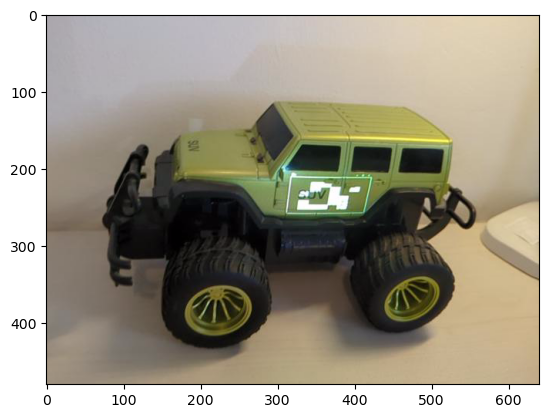

In [ ]:
plt.imshow(frames[203])

In [ ]:
ret, frame = cap.read()
f = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)
cv2.imwrite(r"D:\git\AdversarialRendering\ref.png", f)

True

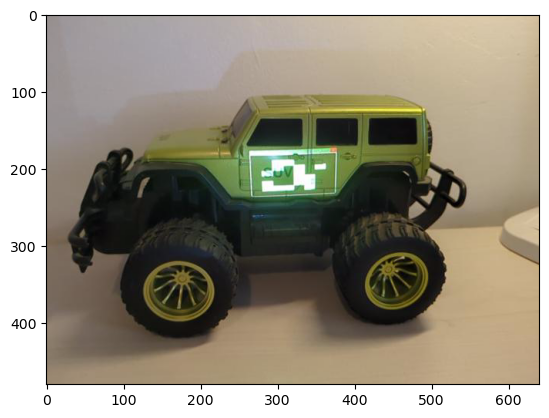

In [ ]:
plt.imshow(f)

In [ ]:
pred_ref_img = cv2.imread(r"D:\git\AdversarialRendering\patches\10_05_pred.png")
# pred_ref_img = cv2.cvtColor(pred_ref_img, cv2.COLOR_BGR2RGB)


In [ ]:
cv2.imshow("a", pred_ref_img)
cv2.waitKey(1)
time.sleep(1)

In [ ]:
for i in range(10):
    ret, frame = cap.read()
frame = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)

frame_t = tt(frame)

In [ ]:
resnet_predict(frame_t.unsqueeze(0).cuda())

'jeep: 0.124%'

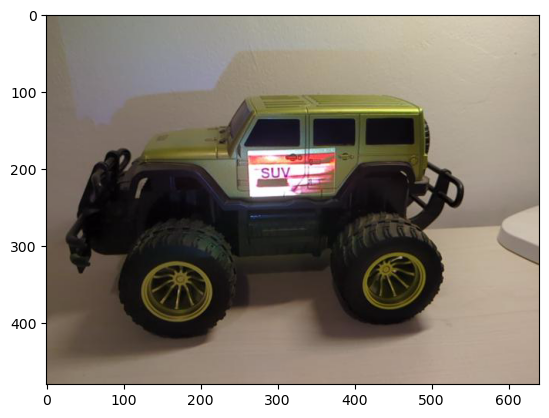

In [ ]:
plt.imshow(frame_t.permute(1,2,0).numpy())

## Clean data

In [ ]:
ret, frame = cap.read()


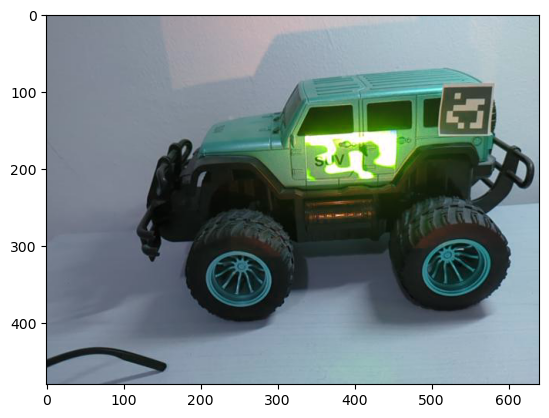

In [ ]:

plt.imshow(frame)

In [19]:

aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
parameters = aruco.DetectorParameters()

# Detect ArUco markers
detector = aruco.ArucoDetector(aruco_dict, parameters)

In [ ]:
valid_frames = []
for frame in tqdm.tqdm(frames):
    with torch.no_grad():
        p = resnet_predict_raw(tt(frame).cuda().unsqueeze(0)).argmax(-1).cpu()

    if p not in orig_clases:
        continue

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Initialize ArUco dictionary and detector parameters
    corners, ids, _ = detector.detectMarkers(gray)

    if ids is None:
        continue
        # Draw detected markers
        # frame = aruco.drawDetectedMarkers(frame, corners, ids)
    valid_frames.append(frame)

 25%|██▍       | 369/1503 [01:46<05:28,  3.45it/s]


KeyboardInterrupt: 

In [ ]:
len(valid_frames)

1316

In [ ]:
import os
valid_frames = frames

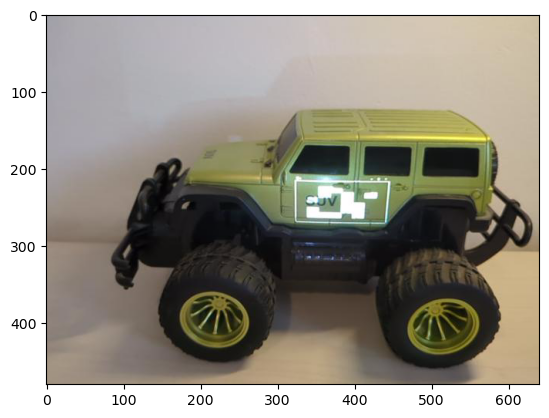

In [ ]:
plt.imshow(frames[10])

In [ ]:
os.makedirs(r"D:\git\AdversarialRendering\multiview\valid_frames3", exist_ok=True)
for i, frame in enumerate(valid_frames):
    cv2.imwrite(os.path.join(r"D:\git\AdversarialRendering\multiview\valid_frames3", f"{i}.png"), frame)

# pose est

In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Initialize ArUco dictionary and detector parameters
aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
parameters = aruco.DetectorParameters()

# Detect ArUco markers
detector = aruco.ArucoDetector(aruco_dict, parameters)


In [43]:
ids

array([[42]], dtype=int32)

In [44]:
corners

(array([[[512., 155.],
         [517.,  95.],
         [579.,  94.],
         [572., 155.]]], dtype=float32),)

In [46]:
# rotM_cam = cv2.Rodrigues(rvec[0])[0]

# # calculate camera position (= translation), in mm from 0,0,0 point
# cameraPosition = -np.matrix(rotM_cam).T * np.matrix(tvec[0])

# # 3x3 Identity matrix
# I = np.identity(3)

# # [I|-C]
# I1_extended = np.hstack((I,-cameraPosition))

# # P = K*R*I
# P_cam = cameraMatrix.dot(rotM_cam).dot(I1_extended)

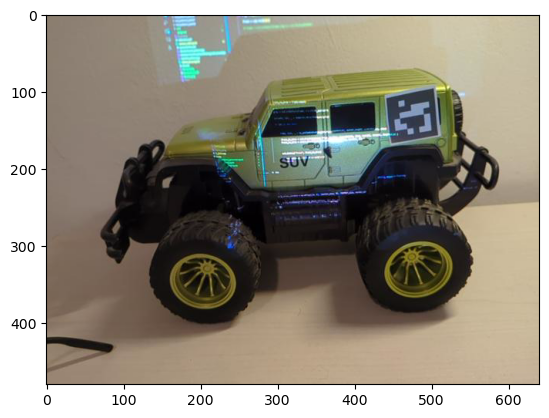

In [97]:
frame = cap.read()[1]

# frame = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)

frame_to_draw = frame.copy()

plt.imshow(cv2.cvtColor(frame_to_draw, cv2.COLOR_BGR2RGB))

# Convert to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

corners, ids, _ = detector.detectMarkers(gray)

if ids is not None:
    

    rvec, tvec, _ = my_estimatePoseSingleMarkers(corners[0], marker_length, cameraMatrix, dist)

else:
    raise


In [98]:
orig_pose = (rvec[0], tvec[0], corners[0][0])

In [107]:
while True:

    frame = cap.read()[1]

    # frame = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)

    frame_to_draw = frame.copy()

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    corners, ids, _ = detector.detectMarkers(gray)

    if ids is not None:
        

        rvec, tvec, _ = my_estimatePoseSingleMarkers(corners[0], marker_length, cameraMatrix, dist)

        diff_tvec = tvec[0] - orig_pose[1]


        frame_to_draw = cv2.drawFrameAxes( frame_to_draw, cameraMatrix, dist, rvec[0], tvec[0], length=0.03 )
        frame_to_draw = aruco.drawDetectedMarkers( frame_to_draw, corners, ids )

        

        cv2.imshow("frame", frame_to_draw)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break




In [108]:
diff_tvec

array([[-0.01735415],
       [ 0.00049855],
       [ 0.00826071]])

In [101]:
orig_pose

(array([[ 1.80726749],
        [-2.0237522 ],
        [-0.16504543]]),
 array([[ 0.12490905],
        [-0.09024255],
        [ 0.89528445]]),
 array([[448., 166.],
        [442., 109.],
        [502.,  96.],
        [508., 156.]], dtype=float32))

In [102]:
diff_tvec = tvec[0] - orig_pose[1]
diff_rvec = rvec[0] - orig_pose[0]

diff_rvec = cv2.Rodrigues(diff_rvec)[0]

In [ ]:
# add diff_tvec to plot


array([[ 0.00926108],
       [-0.00621366],
       [ 0.06282703]])

In [100]:
tvec

[array([[ 0.13417013],
        [-0.09645621],
        [ 0.95811148]])]

In [92]:
orig_aruco_corners = np.array([[0, 0], [marker_size, 0], [marker_size, marker_size], [0, marker_size]], dtype=np.float32)

dst_pts = corners[0][0]

H, _ = cv2.findHomography(orig_aruco_corners, dst_pts, cv2.RANSAC)

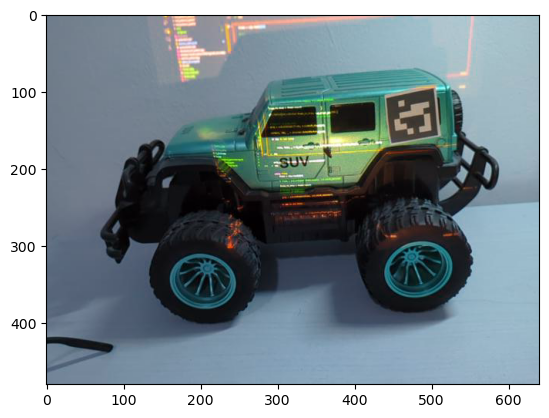

In [93]:
plt.imshow(frame_to_draw)